In [83]:
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from pyBioInfo.IO.File import BedFile, BamFile
from pyBioInfo.Utils import ShiftLoader

# Distribution of relative read density  (Extended Data Figure 5h,i)

In [79]:
samples = ["20241028_293T_HNRNPK_CLIP_Input_Rep1", "20241028_293T_HNRNPK_CLIP_Input_Rep2", "20241028_293T_HNRNPK_CLIP_IP_Rep1", "20241028_293T_HNRNPK_CLIP_IP_Rep2"]

In [213]:
def get_chrom_read_location(bamfile, bedfile, infofile, chrom, outfile):
    info = pd.read_csv(infofile, sep="\t" if infofile.endswith(".tsv") else ",", index_col=0)
    info = info[info["Canonical"]]
    info = info[info["TranscriptType"] == "protein_coding"]
    tids = set(info.index)

    transcripts = []
    with BedFile(bedfile) as f:
        for t in f.fetch(chrom):
            if t.name in tids:
                transcripts.append(t)
    # print(len(transcripts))
    
    loader = ShiftLoader(transcripts)
    n1, n2, n3 = 0, 0, 0
    with BamFile(bamfile, random=True) as f, open(outfile, "w+") as fw:
        for a in f.fetch(chrom):
            pos = a.get_position(int(len(a)/2))
            
            ts = []
            for t in loader.fetch(obj=a):
                if a.strand == t.strand and t.start <= pos < t.end:
                    ts.append(t)
            loc = None
            x = None
            exon_length = None
            intron_length = None
            five_utr_length = None
            cds_length = None
            three_utr_length = None
            
            if len(ts) == 0:
                loc = "Intergenic"
            elif len(ts) == 1:
                n2 += 1
                t = ts[0]
                exon_length = len(t)
                intron_length = t.end - t.start - exon_length
                try:
                    i = t.get_index(pos)
                    loc = "Exon"
                    if t.thick:
                        i1, i2, i3, i4 = t.indexes()
                        five_utr_length = i2 - i1
                        cds_length = i3 - i2
                        three_utr_length = i4 - i3
                        if i1 <= i < i2:
                            x = (i-i1)/(i2-i1)
                        elif i2 <= i < i3:
                            x = 1 + (i-i2)/(i3-i2)
                        else:
                            x = 2 + (i-i3)/(i4-i3)
                except ValueError:
                    loc = "Intron"
            else:
                loc = "MultiGene"
            row = [loc, x, exon_length, intron_length, five_utr_length, cds_length, three_utr_length]
            fw.write("\t".join(map(str, row)) + "\n")

def get_read_location(bamfile, bedfile, infofile, outfile):
    pool = mp.Pool(24)
    chroms = ["chr%s" % c for c in range(1, 23)] + ["chrX", "chrY"]
    outfiles = []
    for chrom in chroms:
        outfile2 = outfile + ".%s.tsv" % chrom
        args = (bamfile, bedfile, infofile, chrom, outfile2)
        pool.apply_async(get_chrom_read_location, args)
        outfiles.append(outfile2)
    pool.close()
    pool.join()

    with open(outfile, "w+") as fw:
        for outfile2 in outfiles:
            for line in open(outfile2):
                fw.write(line)
            ! rm {outfile2}

In [214]:
bedfile = "/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.transcripts.bed.gz"
infofile = "/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.transcript_info.added_canonical.csv"
for sample in samples:
    bamfile = "../../2_seCLIPseq/results/1_pipeline/9_dedup/%s.dedup.sorted.bam" % sample
    outfile = "results/read_location.%s.tsv" % sample
    get_read_location(bamfile, bedfile, infofile, outfile)

In [215]:
rows = []
for sample in samples:
    print("-" * 80)
    path = "results/read_location.%s.tsv" % sample
    print(path)
    counter = defaultdict(int)
    counter2 = defaultdict(int)
    exon_density = 0
    intron_density = 0
    noncoding_density = 0
    five_utr_density = 0
    cds_density = 0
    three_utr_density = 0
    vs1 = []
    vs2 = []
    with open(path) as f:
        for i, line in enumerate(f):
            if i >= 2000000:
                break
            row = line.strip("\n").split("\t")
            loc, x, exon_length, intron_length, five_utr_length, cds_length, three_utr_length = row
            counter[loc] += 1
            if loc == "Exon":
                exon_density += (1/int(exon_length))
                vs1.append(int(exon_length))
            if loc == "Intron":
                counter2["Intron"] += 1
                intron_density += (1/int(intron_length))
                vs2.append(int(intron_length))
                
            if loc == "Exon":
                if x == "None":
                    counter2["NonCoding"] += 1
                    noncoding_density += 1/int(exon_length)
                else:
                    x = float(x)
                    if 0 <= x < 1:
                        counter2["5UTR"] += 1
                        five_utr_density += 1/int(five_utr_length)
                    elif 1 <= x < 2:
                        counter2["CDS"] += 1
                        cds_density += 1/int(cds_length)
                    else:
                        counter2["3UTR"] += 1
                        three_utr_density += 1/int(three_utr_length)
                        
    print("Counter of genomic location:", counter)
    print("Proportion of intron reads:", counter["Intron"]/(counter["Intron"] + counter["Exon"]))
    print("Exon density:", exon_density)
    print("Intron density:", intron_density)
    print("Fold change of density:", intron_density / exon_density)
    print("Counter of gene location:", counter2)
    print("Porpotion of 5UTR:", counter2["5UTR"]/sum(counter2.values()))
    print("Porpotion of CDS:", counter2["CDS"]/sum(counter2.values()))
    print("Porpotion of 3UTR:", counter2["3UTR"]/sum(counter2.values()))
    print("Relative 5UTR density:", five_utr_density/cds_density)
    print("Relative CDS density:", cds_density/cds_density)
    print("Relative 3UTR density:", three_utr_density/cds_density)
    print(np.mean(vs1), np.median(vs1))
    print(np.mean(vs2), np.median(vs2))
    row = [counter["Exon"], counter2["Intron"], counter2["NonCoding"], counter2["5UTR"], counter2["CDS"], counter2["3UTR"],
           exon_density, intron_density, noncoding_density, five_utr_density, cds_density, three_utr_density]
    rows.append(row)
    # break

--------------------------------------------------------------------------------
results/read_location.20241028_293T_HNRNPK_CLIP_Input_Rep1.tsv
Counter of genomic location: defaultdict(<class 'int'>, {'Intergenic': 449348, 'Exon': 253506, 'Intron': 1274063, 'MultiGene': 23083})
Proportion of intron reads: 0.8340461216481874
Exon density: 67.59158418748373
Intron density: 29.604981692820136
Fold change of density: 0.4379980444118994
Counter of gene location: defaultdict(<class 'int'>, {'CDS': 136690, '5UTR': 24438, 'Intron': 1274063, '3UTR': 92378})
Porpotion of 5UTR: 0.015997968013228864
Porpotion of CDS: 0.08948204631018304
Porpotion of 3UTR: 0.06047386402840068
Relative 5UTR density: 1.4197825243299622
Relative CDS density: 1.0
Relative 3UTR density: 0.6009501822797676
5673.0079011936605 4862.0
207749.4319056436 99810.0
--------------------------------------------------------------------------------
results/read_location.20241028_293T_HNRNPK_CLIP_Input_Rep2.tsv
Counter of genomic loc

In [216]:
m = pd.DataFrame(rows, columns=["Exon", "Intron", "NonCoding", "5UTR", "CDS", "3UTR", 
                                "Exon.Density", "Intron.Density", "NonCoding.Density", "5UTR.Density", "CDS.Density", "3UTR.Density"])
m.index = samples

m1 = m[["Intron", "5UTR", "CDS", "3UTR"]]
m1.sum(axis=1)
m1 = m1.divide(m1.sum(axis=1), axis=0)

m2 = m[["Intron.Density", "5UTR.Density", "CDS.Density", "3UTR.Density"]]
m2.sum(axis=1)
m2 = m2.divide(m2.sum(axis=1), axis=0)

Intron    0.842338
5UTR      0.013739
CDS       0.084662
3UTR      0.059261
dtype: float64


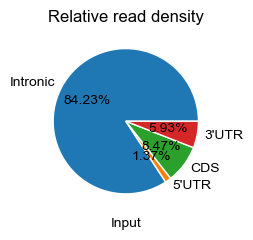

Intron    0.852454
5UTR      0.017597
CDS       0.058135
3UTR      0.071814
dtype: float64


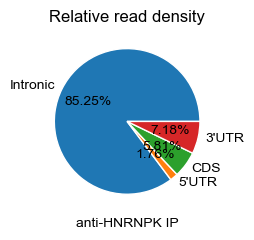

Intron.Density    0.120914
5UTR.Density      0.388021
CDS.Density       0.303362
3UTR.Density      0.187703
dtype: float64
Intron.Density    0.161146
5UTR.Density      0.387520
CDS.Density       0.173748
3UTR.Density      0.277587
dtype: float64


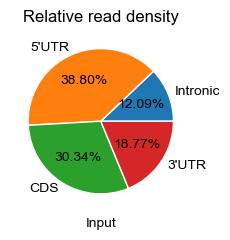

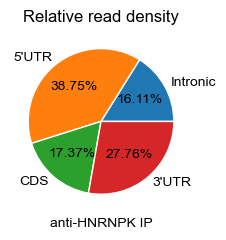

In [236]:
labels = ["Intronic", "5'UTR", "CDS", "3'UTR"]
colors = ["orange", "tomato", "skyblue", "pink"]
colors = ["C0", "C1", "C2", "C3"]
for m3 in [m1, m2]:
    for i in range(2):
        vs= m3.iloc[np.arange(i*2,i*2+2)].mean()
        labels2 = labels
        plt.figure(figsize=(3, 2.5))
        plt.title("Relative read density")
        plt.pie(vs, 
                autopct=lambda x: "%.2f%%" % x, 
                # textprops=dict(color="w"), 
                wedgeprops=dict(width=1, edgecolor='w'), 
                colors=colors, 
                labels=labels2)
        plt.xlabel("Input" if i == 0 else "anti-HNRNPK IP")
        plt.tight_layout()
        if m3 is m1:
            plt.show()
        else:
            plt.savefig("figures/read_density.%s.pdf" % ("input" if i == 0 else "ip"))